# Test K-means

To run this notebook on Swan you just need to install python wordcloud package for the tokenclouds visualisation. Guide here: https://gvolpi.blogspot.com/2017/10/customize-your-cern-swan-python-analysis.html

If you want to run it locally, then you also need to install spark.

Also the results depend on the word2vec model (you can train and use your own, otherwise I can provide a pre-trained version for testing).

Finally, test data are available here: https://cernbox.cern.ch/index.php/s/8fAkH7yohwI8AOI

##### Start Spark session

In [1]:
%%time

# start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("fts_clustering").getOrCreate()
#spark = SparkSession.builder.master("local[*]").appName("fts_data").getOrCreate()
spark

CPU times: user 44.5 ms, sys: 30.9 ms, total: 75.4 ms
Wall time: 10.7 s


##### Read data and transform to pyspark dataframe 

In [14]:
import pandas as pd

pd_test_data = pd.read_csv("fts_mess_panda.csv", index_col="Unnamed: 0")
test_data = spark.createDataFrame(pd_test_data)
test_data.limit(10).select("message").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|message                                                                                                                                                                                                                                                                                                                                                                                     |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### Custom functions to help tokenisation 

In [9]:
def deal_with_urls(url):
    from urllib.parse import urlparse
    parsed = urlparse(url)
    if parsed.scheme:
        if parsed.path and parsed.netloc:
            res = ' '.join([parsed.scheme + "://" + parsed.netloc, parsed.path])
        elif parsed.path:
            res = parsed.scheme + ":" + parsed.path
        else:
            res = parsed.scheme + ":"
    elif parsed.params:
        res = ' '.join([parsed.path.strip("."), parsed.params])
    else:
        res = parsed.path
    return(res)

def split_urls(string):
    '''Take a string and split url into netloc + path'''
    from urllib.parse import urlparse
    tks = [deal_with_urls(x) for x in string.split()]
    return(' '.join(tks))


def split_concatenation_errors(string, split_char="-"):
    """"""   
    if split_char in string:
        try:
            int(string.split(split_char)[0])
            number = string.split(split_char)[0]
            literal = string.replace(number+split_char, "")
            return([number, literal])
        except ValueError:
            return(string)
    else:
        return(string)

def clean_tokens(entry, custom_split=False):
    """Remove punctuation at the end of tokens and disard empty tokens"""
    def flatten(ul):
        """"""
        fl = []
        for i in ul:
            if type(i) is list:
                fl += flatten(i)
            else:
                fl += [i]
        return fl
    
    if custom_split:
        tks_cleaned = [split_concatenation_errors(tks.strip(":;,.- ")) 
                       for tks in entry if tks!=""]
        tks_cleaned = flatten(tks_cleaned)
    else:
        tks_cleaned = [tks.strip(":;,.- ") for tks in entry if tks!=""]
    return(tks_cleaned)

In [10]:
test_data.columns

['message', 'count', 'id']

##### Strings pre-processing 

In [16]:
import pyspark.sql.functions as F

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType

# transform in user defined function
split_urls_udf = udf(split_urls, StringType())

# split urls appropriately
test_data = test_data.select("id", "message").distinct().withColumn("corrected_message", split_urls_udf("message"))

# add row id
test_data = test_data.select("id", "message", "corrected_message")

##### Tokenisation 

In [17]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# split text into tokens
tokenizer = Tokenizer(inputCol="corrected_message", outputCol="tokens")
vector_data = tokenizer.transform(test_data)

# transform in user defined function
clean_tokens_udf = udf(lambda entry: clean_tokens(entry, custom_split=True), ArrayType(StringType()))

# clean tokens
vector_data = vector_data.withColumn("tokens_cleaned", clean_tokens_udf("tokens"))

# remove stop (common, non-relevant) words
stop_remove = StopWordsRemover(inputCol="tokens_cleaned", outputCol="stop_token")
stop_remove1 = StopWordsRemover(inputCol="stop_token", outputCol="stop_token_1", stopWords=["", ":", "-", "+"])

In [18]:
from pyspark.ml import Pipeline

data_prep_pipeline = Pipeline(stages = [stop_remove, stop_remove1])

pipeline_executor = data_prep_pipeline.fit(vector_data)

In [19]:
%%time

vector_data = pipeline_executor.transform(vector_data)

CPU times: user 50.3 ms, sys: 14.5 ms, total: 64.8 ms
Wall time: 386 ms


In [20]:
vector_data.count()

22792

<div class="alert alert-block alert-info">
    <b>Note:</b> The initial dataset consists of ~23k FTS unique error messages extracted from one full day of operations. 
</div>

## Embedding

First step is to apply word2vec model to obtain the embedded representation of tokens contained in the messages.

In [22]:
# load back the word2vec model
from pyspark.ml.feature import Word2VecModel
w2vec_model = Word2VecModel.load('word2vec_trial_random_sample')

# apply it to the data to obtain the embedded representation
# train_data = sub1.select("msg_id", "t__error_message", "stop_token_1")#.limit(500000)
train_data = vector_data.select("id", "message", "stop_token_1")#.limit(500000)
train_data = w2vec_model.transform(train_data)

In [23]:
# from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
vec_assembler = VectorAssembler(inputCols = ["message_vector"], outputCol='features')
# format data to feed it into pyspark ML models
train_data = vec_assembler.transform(train_data)
train_data.limit(1).show(truncate=False)

+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<div class="alert alert-block alert-warning">
    <b>Note:</b> Apparently pyspark.ml word2vec model produce a <i>token-wise</i> representation that is then automatically "combined" to get a <i>message-wise</i> representation. 
However this mechanism is still under investigation.
</div>

## Clustering
Once we have the embedded representation, we can apply our clustering algorithm.

### K-Means

#### Choice of K

The K-Means algorithm depends on the parameter *K*, i.e. the number of clusters.

In order to choose the optimal value for the number of clusters, K, I compare the results obtained with different Ks based on two metrics:

 - Sum of Squared Distances Within Groups: $$ \text{WSSE}(\text{dist}, K) = \sum_{k=1}^{K}{\sum_{x_i \in C_k}\text{dist}(x_i, \overline{x}_k)}$$
 
 - Average Silhouette Width: $$ \text{ASW}(\text{dist}, K) = \frac{1}{n} \sum_{i=1}^{n}{\frac{b(i) - a(i)}{\text{max}[a(i), b(i)]}}$$
 where $a(i)$ is the average distance of message $i$ to all the other messages in the same cluster and $b(i)$ is the minimum average distance of message $i$ from messages on another cluster.

In [36]:
%%time

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import time
import datetime

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

kmeans_models = []
clustering_model = []
wsse = []
silhouette = []


k_list = []
for i, k in enumerate(range(5,21)):
    k_list.append(k)
    
    start_time = time.time()
    start_time_string = datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
    print("Started at: {}\n".format(start_time_string))
    
    kmeans_models.append(KMeans(featuresCol='features',k=k, initMode='k-means||',
    initSteps=10, tol=0.0001, maxIter=30, distanceMeasure='cosine'))
    clustering_model.append(kmeans_models[i].fit(train_data))
    
    # compute metrics   
    wsse.append(clustering_model[i].summary.trainingCost)
    silhouette.append(evaluator.evaluate(clustering_model[i].summary.predictions))
    
    
    print("With K={}".format(k))
    print("Within Cluster Sum of Squared Errors = " + str(wsse[i]))
    print("Silhouette with cosine distance = " + str(silhouette[i]))
    
    print("\nTime elapsed: {} minutes and {} seconds.".format(int((time.time() - start_time)/60), int((time.time() - start_time)%60)))
    print('--'*30)

Started at: 2019-12-04 15:26:22

With K=5
Within Cluster Sum of Squared Errors = 2680.0982669765613
Silhouette with cosine distance = 0.47326305152059284

Time elapsed: 0 minutes and 55 seconds.
------------------------------------------------------------
Started at: 2019-12-04 15:27:18

With K=6
Within Cluster Sum of Squared Errors = 1882.8915879620463
Silhouette with cosine distance = 0.600243195668007

Time elapsed: 0 minutes and 57 seconds.
------------------------------------------------------------
Started at: 2019-12-04 15:28:15

With K=7
Within Cluster Sum of Squared Errors = 1397.229906217087
Silhouette with cosine distance = 0.659169011095473

Time elapsed: 0 minutes and 48 seconds.
------------------------------------------------------------
Started at: 2019-12-04 15:29:03

With K=8
Within Cluster Sum of Squared Errors = 1978.5158369582646
Silhouette with cosine distance = 0.4643201360222503

Time elapsed: 0 minutes and 51 seconds.
-------------------------------------------

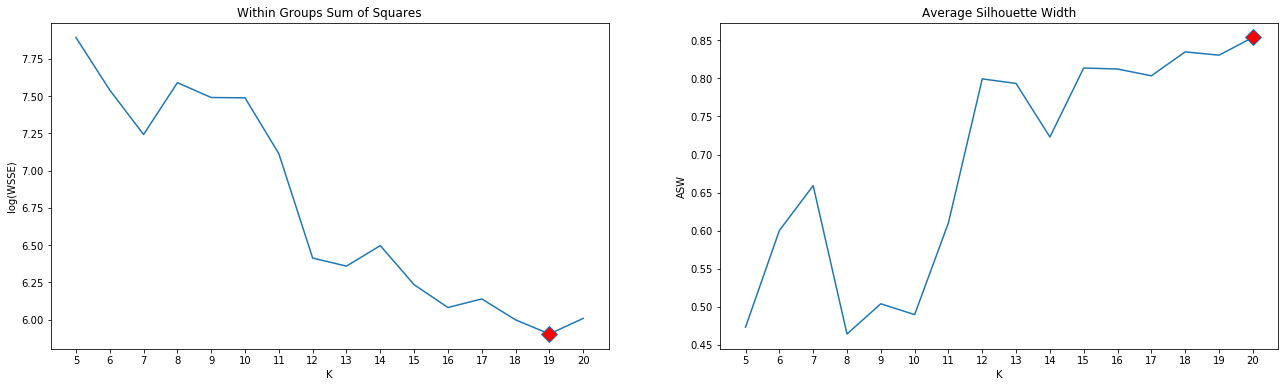

In [37]:
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(22,6))

best_K_wsse = np.argmin(wsse)
best_K_silhouette = np.argmax(silhouette)

_ = plt.subplot(1,2,1)
_ = plt.plot(k_list, np.log(wsse),'-D', markevery=[best_K_wsse], markerfacecolor='red', markersize=12)
# _ = plt.Circle(xy=(16,16257), radius=3, color="red")
_ = plt.xlabel("K")
_ = plt.ylabel("log(WSSE)")
_ = plt.xticks(k_list)
_ = plt.title("Within Groups Sum of Squares")

_ = plt.subplot(1,2,2)
_ = plt.plot(k_list, silhouette,'-D', markevery=[best_K_silhouette], markerfacecolor='red', markersize=12)
_ = plt.xlabel("K")
_ = plt.ylabel("ASW")
_ = plt.xticks(k_list)
_ = plt.title("Average Silhouette Width")
plt.show()

The lower the Within Groups Sum of Squared Distances (WSSE) the better. On the other hand, the Average Silhouette Width (ASW) is more indicative of the performance as it is bounded in the interval [-1, 1]:

$$
\begin{cases}
1 \leftarrow \text{clusters are internally compact and well separated} \\
0 \leftarrow \text{clusters are not well separated} \\
-1 \leftarrow \text{clusters are internally heterogeneous and overlapping} \\
\end{cases} $$

Since there is arguably little differences among results obtained with 12 or more clusters, then I try to inspect the once obtained with K=12 since it is more conservative.

#### Posterior checks 
First thing I can look at is the number of messages per custer (note: these are all different since we started from unique messages):

In [38]:
import numpy as np

for model in clustering_model:
    print("\n\nkmeans: K = {}".format(model.summary.k))
    print("Maximum number of iterations: {}".format(model.summary.numIter))
    
    # sort cluster sizes
    ord_sizes = model.summary.clusterSizes
    ord_idx = list(np.argsort(model.summary.clusterSizes))
    ord_sizes.sort(reverse=True)
    ord_idx.reverse()
    print("Cluster sizes:")
    for el in zip(ord_idx, ord_sizes):
        print("{}".format(el))



kmeans: K = 5
Maximum number of iterations: 3
Cluster sizes:
(0, 13848)
(4, 4562)
(3, 1942)
(1, 1657)
(2, 783)


kmeans: K = 6
Maximum number of iterations: 3
Cluster sizes:
(0, 11987)
(4, 4482)
(1, 2417)
(5, 2218)
(3, 1490)
(2, 198)


kmeans: K = 7
Maximum number of iterations: 3
Cluster sizes:
(0, 11854)
(3, 3078)
(1, 2414)
(5, 2311)
(6, 1484)
(2, 988)
(4, 663)


kmeans: K = 8
Maximum number of iterations: 3
Cluster sizes:
(0, 13689)
(5, 2802)
(1, 1657)
(6, 1581)
(4, 1061)
(3, 975)
(2, 776)
(7, 251)


kmeans: K = 9
Maximum number of iterations: 3
Cluster sizes:
(0, 13689)
(1, 2407)
(5, 2131)
(6, 1582)
(3, 1065)
(8, 972)
(4, 508)
(7, 237)
(2, 201)


kmeans: K = 10
Maximum number of iterations: 3
Cluster sizes:
(0, 13689)
(1, 2407)
(5, 2131)
(6, 1518)
(3, 1064)
(9, 972)
(4, 508)
(7, 237)
(2, 201)
(8, 65)


kmeans: K = 11
Maximum number of iterations: 3
Cluster sizes:
(0, 12220)
(5, 2129)
(1, 1656)
(6, 1584)
(10, 1482)
(3, 1117)
(7, 812)
(4, 757)
(9, 657)
(2, 201)
(8, 177)


kmeans: K

#####  Abstraction

However, clusters tend to have similar messages that are different by some parameter value (e.g. URL, PATH, ...). Hence, I try to abstract these quantities to get an indication of the number of different "typologies" which is more fair:

In [39]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType

def is_url(string):
    if string.find("://") != -1:
        return(True)
    return(False)
    

def is_ipv6(string):
    import numpy as np
    is_column = [1 if x==":" else 0 for x in string]
    if np.sum(is_column) >= 3 and string.find("/") == -1:
        return(True)
    return(False)

def is_address(string):
    import numpy as np
    is_point = [1 if x=="." else 0 for x in string]
    if np.sum(is_point) >= 2 and string.find("/") == -1:
        return(True)
    return(False)

def is_path(string):
    if string.startswith("path="):
        return(True)
    return(False)

def is_file_path(string):
    if string.startswith("/") and all(char in string[1:] for char in [".", "/"]):
        return(True)
    return(False)

def is_net_param(string):
    if string.startswith("[net="):
        return(True)
    return(False)

def is_filesize_mismatch(string):
    if string.startswith("(expected="):
        res = "$EXPECTED_SIZE"
    elif string.startswith("actual="):
        res = "$ACTUAL_SIZE"
    else:
        res = False
    return(res)

def is_remote_entity(string):
    if string.startswith("(/cn="):
        res = "$EXPECTED_REMOTE_ENTITY"
    elif string.startswith("(/dc="):
        res = "$ACTUAL_REMOTE_ENTITY"
    else:
        res = False
    return(res)
    
def replace_address(string, replace_string=None):
    if not replace_string:
        if is_url(string):
            string = "$URL"
        elif is_ipv6(string):
            string = "$IPv6"
        elif is_address(string):
            string = "$ADDRESS"
        elif is_path(string):
            string = "$PATH"
        elif is_file_path(string):
            string = "$FILE_PATH"
        elif is_net_param(string):
            string = "$NET_PARAM"
        elif is_filesize_mismatch(string):
            string = is_filesize_mismatch(string)
        elif is_remote_entity(string):
            string = is_remote_entity(string)
    else:
        if is_url(string) or is_ipv6(string) or is_address(string) or is_path(string):
            string = replace_string
    return(string)

def replace_IDS(tokens_list, ID_precursors=["transaction", "process", "message", "relation", "database", "tuple"]):
    import re
    msg_pattern = re.compile("<[0-9]+:[0-9]+>")
    precursor_flags = [False]*len(ID_precursors)
    
    res = []
    for tkn in tokens_list:
        
        if True in precursor_flags:
            i = precursor_flags.index(True)
            if ID_precursors[i]=="message" and not msg_pattern.match(tkn):
                res.append(tkn)
                precursor_flags[i]=False
                next
            res.append("${}_ID".format(ID_precursors[i].upper()))
            precursor_flags[i]=False
        else:
            res.append(tkn)
        
        if tkn in ID_precursors:
            precursor_flags[ID_precursors.index(tkn)]=True
    return(res)

def abstract_message(tokens_list):
    '''Take a string and split url into netloc + path'''
    tks = [replace_address(x) for x in tokens_list]
    tks = replace_IDS(tks)
    return(tks)

# transform in user defined function
abstract_message_udf = udf(abstract_message, ArrayType(StringType()))

In [80]:
import pyspark.sql.functions as F

for model in clustering_model:
    print("\n\nkmeans: K = {}".format(model.summary.k))

    data_subset = model.summary.predictions
    data_subset = data_subset.withColumn("abstract_tokens", abstract_message_udf("stop_token_1"))

    grouped_pred = data_subset.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("abstract_tokens").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)



kmeans: K = 5
+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|1         |1637         |
|2         |783          |
|0         |529          |
|4         |162          |
|3         |141          |
+----------+-------------+



kmeans: K = 6
+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|1         |2396         |
|0         |564          |
|3         |107          |
|4         |92           |
|5         |61           |
|2         |34           |
+----------+-------------+



kmeans: K = 7
+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|1         |2393         |
|0         |522          |
|4         |110          |
|3         |103          |
|5         |56           |
|2         |38           |
|6         |30           |
+----------+-------------+



kmeans: K = 8
+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|1         |1637         |
|2         |776

### Best K

Once I choose the value of *K*, then I re-train the model with more initialisations in the hope of improving the model.

In [46]:
%%time

import time
import datetime

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

# kmeans_models = []
# clustering_model = []


k_best = 12 # k_list.index(8)


start_time = time.time()
start_time_string = datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print("Started at: {}\n".format(start_time_string))
    
# for i, k in enumerate([k_best]):
kmeans_models_best = KMeans(featuresCol='features',k=k_best, initMode='k-means||',
                            initSteps=100, tol=0.000001, maxIter=50, distanceMeasure='cosine')
clustering_model_best = kmeans_models_best.fit(train_data)

# compute metrics   \
wsse_best = clustering_model_best.summary.trainingCost
silhouette_best = evaluator.evaluate(clustering_model_best.summary.predictions)

print("With K={}".format(k_best))
print("Within Cluster Sum of Squared Errors = " + str(wsse_best))
print("Silhouette with cosine distance = " + str(silhouette_best))

print("\nTime elapsed: {} minutes and {} seconds.".format(int((time.time() - start_time)/60),
                                                          int((time.time() - start_time)%60)))
    
print('--'*30)

Started at: 2019-12-04 15:55:24

With K=12
Within Cluster Sum of Squared Errors = 808.5151597047069
Silhouette with cosine distance = 0.7512090475221853

Time elapsed: 2 minutes and 8 seconds.
------------------------------------------------------------
CPU times: user 2.68 s, sys: 1.82 s, total: 4.5 s
Wall time: 2min 8s


In [47]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType

def is_url(string):
    if string.find("://") != -1:
        return(True)
    return(False)
    

def is_ipv6(string):
    import numpy as np
    is_column = [1 if x==":" else 0 for x in string]
    if np.sum(is_column) >= 3 and string.find("/") == -1:
        return(True)
    return(False)

def is_address(string):
    import numpy as np
    is_point = [1 if x=="." else 0 for x in string]
    if np.sum(is_point) >= 2 and string.find("/") == -1:
        return(True)
    return(False)

def is_path(string):
    if string.startswith("path="):
        return(True)
    return(False)

def is_file_path(string):
    if string.startswith("/") and all(char in string[1:] for char in [".", "/"]):
        return(True)
    return(False)

def is_net_param(string):
    if string.startswith("[net="):
        return(True)
    return(False)

def is_filesize_mismatch(string):
    if string.startswith("(expected="):
        res = "$EXPECTED_SIZE"
    elif string.startswith("actual="):
        res = "$ACTUAL_SIZE"
    else:
        res = False
    return(res)

def is_remote_entity(string):
    if string.startswith("(/cn="):
        res = "$EXPECTED_REMOTE_ENTITY"
    elif string.startswith("(/dc="):
        res = "$ACTUAL_REMOTE_ENTITY"
    else:
        res = False
    return(res)
    
def replace_address(string, replace_string=None):
    if not replace_string:
        if is_url(string):
            string = "$URL"
        elif is_ipv6(string):
            string = "$IPv6"
        elif is_address(string):
            string = "$ADDRESS"
        elif is_path(string):
            string = "$PATH"
        elif is_file_path(string):
            string = "$FILE_PATH"
        elif is_net_param(string):
            string = "$NET_PARAM"
        elif is_filesize_mismatch(string):
            string = is_filesize_mismatch(string)
        elif is_remote_entity(string):
            string = is_remote_entity(string)
    else:
        if is_url(string) or is_ipv6(string) or is_address(string) or is_path(string):
            string = replace_string
    return(string)

def replace_IDS(tokens_list, ID_precursors=["transaction", "process", "message", "relation", "database", "tuple"]):
    import re
    msg_pattern = re.compile("<[0-9]+:[0-9]+>")
    precursor_flags = [False]*len(ID_precursors)
    
    res = []
    for tkn in tokens_list:
        
        if True in precursor_flags:
            i = precursor_flags.index(True)
            if ID_precursors[i]=="message" and not msg_pattern.match(tkn):
                res.append(tkn)
                precursor_flags[i]=False
                next
            res.append("${}_ID".format(ID_precursors[i].upper()))
            precursor_flags[i]=False
        else:
            res.append(tkn)
        
        if tkn in ID_precursors:
            precursor_flags[ID_precursors.index(tkn)]=True
    return(res)

def abstract_message(tokens_list):
    '''Take a string and split url into netloc + path'''
    tks = [replace_address(x) for x in tokens_list]
    tks = replace_IDS(tks)
    return(tks)

# transform in user defined function
abstract_message_udf = udf(abstract_message, ArrayType(StringType()))

##### NO ABSTRACTION

In [48]:
import pyspark.sql.functions as F

data_subset_no_abs = clustering_model_best.summary.predictions
data_subset_no_abs = data_subset_no_abs.withColumn("abstract_tokens", abstract_message_udf("stop_token_1"))

grouped_pred1 = data_subset_no_abs.groupBy("prediction")
grouped_pred_agg1 = grouped_pred1.agg(F.countDistinct("message").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False)
grouped_pred_agg1.withColumnRenamed("prediction", "cluster_label").show(truncate=False)
# agg_summary1 = grouped_pred_agg1.toPandas()

+-------------+-------------+
|cluster_label|n_unique_mess|
+-------------+-------------+
|11           |10024        |
|0            |2976         |
|5            |2129         |
|1            |1655         |
|6            |1578         |
|10           |1395         |
|7            |971          |
|3            |756          |
|4            |508          |
|8            |367          |
|9            |230          |
|2            |203          |
+-------------+-------------+



##### ABSTRACTION

In [49]:
import pyspark.sql.functions as F

data_subset = clustering_model_best.summary.predictions
data_subset = data_subset.withColumn("abstract_tokens", abstract_message_udf("stop_token_1")).dropDuplicates(['abstract_tokens'])
data_subset.cache()
grouped_pred = data_subset.groupBy("prediction")
grouped_pred_agg = grouped_pred.agg(F.countDistinct("abstract_tokens").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False)
grouped_pred_agg.show(truncate=False)
agg_summary = grouped_pred_agg.toPandas()

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|1         |1635         |
|3         |756          |
|11        |220          |
|8         |204          |
|9         |126          |
|6         |93           |
|0         |59           |
|5         |47           |
|2         |31           |
|7         |30           |
|4         |28           |
|10        |23           |
+----------+-------------+



<div class="alert alert-block alert-warning">
    <b>Note:</b> Is abstraction good and general enough?
</div>

##  Visualisation

### Sample messages 

In [51]:
import pandas as pd
from termcolor import colored

pd.set_option('display.max_colwidth', -1)

big_cluster_threshold = 1
clust_ids = list(agg_summary.prediction[agg_summary.n_unique_mess >=big_cluster_threshold])

# data_subset = clustering_model_best.summary.predictions.withColumn("abstract_tokens", abstract_message_udf("stop_token_1")).dropDuplicates(['abstract_tokens'])

# clust_ids.reverse()

n_mess_to_show = 10
for idx, clust_id in enumerate(clust_ids):

    print( colored("Cluster n.{}".format(clust_id), 'red'))
    
    perc = min(n_mess_to_show/agg_summary.n_unique_mess[idx],1.)
    cluster = data_subset.filter("prediction == {}".format(clust_id)).sample(withReplacement=False, fraction=perc)

    # In case of pyspark dataframe format for cluster
#     nrows = agg_summary.n_unique_mess[agg_summary.prediction==clust_id].values[0]
#     cluster_unique_messages.show(n=int(nrows), truncate=False)
    
    # In case of pandas dataframe format for cluster
    cluster_unique_messages = cluster.select("message", "abstract_tokens").toPandas()
    for idx, row in enumerate(cluster_unique_messages.values):
        print( colored("Row_id: {}.".format(idx), 'blue'))
        print("Message:\n", row[0], "\n")
        print("Abstraction:\n", row[1], "\n\n")

Cluster n.1
Row_id: 0.
Message:
 TRANSFER CHECKSUM MISMATCH Source and destination checksums do not match 3e0cbd6c != 01aabd6c 

Abstraction:
 ['transfer', 'checksum', 'mismatch', 'source', 'destination', 'checksums', 'match', '3e0cbd6c', '!=', '01aabd6c'] 


Row_id: 1.
Message:
 TRANSFER CHECKSUM MISMATCH Source and destination checksums do not match 81f94f4c != 86c94f4c 

Abstraction:
 ['transfer', 'checksum', 'mismatch', 'source', 'destination', 'checksums', 'match', '81f94f4c', '!=', '86c94f4c'] 


Row_id: 2.
Message:
 SOURCE CHECKSUM MISMATCH User defined checksum and source checksum do not match 312274e8 != 6c97854e 

Abstraction:
 ['source', 'checksum', 'mismatch', 'user', 'defined', 'checksum', 'source', 'checksum', 'match', '312274e8', '!=', '6c97854e'] 


Row_id: 3.
Message:
 SOURCE CHECKSUM MISMATCH User defined checksum and source checksum do not match d78789a1 != 537549c4 

Abstraction:
 ['source', 'checksum', 'mismatch', 'user', 'defined', 'checksum', 'source', 'checksum'

Row_id: 0.
Message:
 TRANSFER  globus_ftp_client: the server responded with an error 530 Login incorrect. : Server over the global connection limit of 100 (user has 0 transfers) (host=gftp3.hep.kbfi.ee, user=cms, path=(null))    

Abstraction:
 ['transfer', 'globus_ftp_client', 'server', 'responded', 'error', '530', 'login', 'incorrect', 'server', 'global', 'connection', 'limit', '100', '(user', '0', 'transfers)', '$ADDRESS', 'user=cms', '$PATH'] 


Row_id: 1.
Message:
 globus_ftp_client: the server responded with an error 421 Idle Timeout: closing control connection.    

Abstraction:
 ['globus_ftp_client', 'server', 'responded', 'error', '421', 'idle', 'timeout', 'closing', 'control', 'connection'] 


Row_id: 2.
Message:
 Error on XrdCl::CopyProcess::Run(): [ERROR] Server responded with an error: [3003] Output file /xrd/dteam/doma/root/test/SLAC-XRD_X-stress-file-4GB-c9b0 is already opened by 1 writer; open denied.  

Abstraction:
 ['error', '$IPv6', '[error]', 'server', 'responded',

Row_id: 0.
Message:
 globus_ftp_client: the server responded with an error 500 500-Command failed : System error in stat: No such file or directory  500-A system call failed: No such file or directory  500 End.    

Abstraction:
 ['globus_ftp_client', 'server', 'responded', 'error', '500', '500', 'command', 'failed', 'system', 'error', 'stat', 'file', 'directory', '500', 'system', 'call', 'failed', 'file', 'directory', '500', 'end'] 


Row_id: 1.
Message:
 TRANSFER  globus_ftp_client: the server responded with an error 500 500-Command failed. : globus_xio: System error in writev: Connection reset by peer  500-globus_xio: A system call failed: Connection reset by peer  500-  500 End.    

Abstraction:
 ['transfer', 'globus_ftp_client', 'server', 'responded', 'error', '500', '500', 'command', 'failed', 'globus_xio', 'system', 'error', 'writev', 'connection', 'reset', 'peer', '500', 'globus_xio', 'system', 'call', 'failed', 'connection', 'reset', 'peer', '500', '500', 'end'] 


Row_id: 2.

Row_id: 0.
Message:
 DESTINATION OVERWRITE   Result Could not connect to server after 1 attempts 

Abstraction:
 ['destination', 'overwrite', 'result', 'connect', 'server', '1', 'attempts'] 


Row_id: 1.
Message:
 DESTINATION MAKE_PARENT srm-ifce err: Communication error on send, err: [SE][Mkdir][SRM_INTERNAL_ERROR] httpg://lcg-se1.sfu.computecanada.ca:8443/srm/managerv2: srm://lcg-se1.sfu.computecanada.ca/atlas/atlasdatadisk/rucio/mc16_13TeV/40/3f: Internal name space timeout  

Abstraction:
 ['destination', 'make_parent', 'srm-ifce', 'err', 'communication', 'error', 'send', 'err', '[se][mkdir][srm_internal_error]', '$URL', '/srm/managerv2', '$URL', '/atlas/atlasdatadisk/rucio/mc16_13tev/40/3f', 'internal', 'name', 'space', 'timeout'] 


Row_id: 2.
Message:
 DESTINATION MAKE_PARENT srm-ifce err: Communication error on send, err: [SE][Mkdir][SRM_INTERNAL_ERROR] httpg://lcg-se1.sfu.computecanada.ca:8443/srm/managerv2: srm://lcg-se1.sfu.computecanada.ca/atlas/atlasdatadisk/rucio/mc16_13T

Row_id: 0.
Message:
 DESTINATION SRM_PUTDONE call to srm_ifce error: [SE][PutDone][] httpg://atlasse.lnf.infn.it:8446/srm/managerv2: CGSI-gSOAP running on fts802.cern.ch reports Error reading token data header: Connection reset by peer  

Abstraction:
 ['destination', 'srm_putdone', 'call', 'srm_ifce', 'error', '[se][putdone][]', '$URL', '/srm/managerv2', 'cgsi-gsoap', 'running', '$ADDRESS', 'reports', 'error', 'reading', 'token', 'data', 'header', 'connection', 'reset', 'peer'] 


Row_id: 1.
Message:
 globus_xio: System error in send: Connection reset by peer globus_xio: A system call failed: Connection reset by peer  

Abstraction:
 ['globus_xio', 'system', 'error', 'send', 'connection', 'reset', 'peer', 'globus_xio', 'system', 'call', 'failed', 'connection', 'reset', 'peer'] 


Row_id: 2.
Message:
 DESTINATION SRM_PUT_TURL srm-ifce err: Communication error on send, err: [SE][PrepareToPut][] httpg://osg-se.sprace.org.br:8443/srm/managerv2: CGSI-gSOAP running on fts437.cern.ch reports

<div class="alert alert-block alert-warning">
    <b>Note:</b> Abstraction to be improved: e.g. cluster 1 has similar messages with different CHECKSUMS
</div>

### Retrieve tokens per cluster 

Reading all the messages in each cluster to assess performances is very time-consuming and hardly feasible if one wants to experiment with more training iterations. 

To mitigate this problem, I try to establish some visualisation that should:
- show at first sight a general overview of cluster contents
- highlight main interpretation of the cluster
- allow to detect possibly wrong contents that are mistakenly attached to the cluster

To do that, I try to work on tokens present in each cluster, so I create a vocabulary per every cluster and then I try to attach a measure of how relevant each token is to each cluster.

In [53]:
import pandas as pd
from termcolor import colored

pd.set_option('display.max_colwidth', -1)

# big_cluster_threshold = 1
clust_ids = list(agg_summary.prediction)

# data_subset = clustering_model_best.summary.predictions.withColumn("abstract_tokens", abstract_message_udf("stop_token_1")).dropDuplicates(['abstract_tokens'])

# clust_ids.reverse()
cluster_documents = []
for idx, clust_id in enumerate(clust_ids):
    cluster = data_subset.filter("prediction == {}".format(clust_id))
    cluster_document = []
    for mess in cluster.select("abstract_tokens").collect():
        cluster_document.extend(mess[0])
    cluster_documents.append(cluster_document)
    
agg_summary["cluster_tokens"] = cluster_documents
grouped_pred_agg = spark.createDataFrame(agg_summary)
grouped_pred_agg.cache()
grouped_pred_agg.show()

+----------+-------------+--------------------+
|prediction|n_unique_mess|      cluster_tokens|
+----------+-------------+--------------------+
|         1|         1635|[source, checksum...|
|         3|          756|[transfer, checks...|
|        11|          220|[transfer, globus...|
|         8|          204|[error, $IPv6, [e...|
|         9|          126|[source, srm_get_...|
|         6|           93|[transfer, globus...|
|         0|           59|[transfer, globus...|
|         5|           47|[destination, ove...|
|         2|           31|[transfer, proces...|
|         7|           30|[destination, srm...|
|         4|           28|[file, directory,...|
|        10|           23|[transfer, globus...|
+----------+-------------+--------------------+



In [54]:
from pyspark.ml.feature import CountVectorizer, IDF

# count frequency of each token in each text (bag of words model)
count_vec = CountVectorizer(inputCol="cluster_tokens", outputCol="token_freq")
count_vec_model = count_vec.fit(grouped_pred_agg)
tks_freq = count_vec_model.transform(grouped_pred_agg)
idf = IDF(inputCol="token_freq", outputCol="tf_idf")
tks_freq = idf.fit(tks_freq).transform(tks_freq)
tks_freq.cache()
tks_freq.show()

+----------+-------------+--------------------+--------------------+--------------------+
|prediction|n_unique_mess|      cluster_tokens|          token_freq|              tf_idf|
+----------+-------------+--------------------+--------------------+--------------------+
|         1|         1635|[source, checksum...|(6119,[0,1,2,3,4,...|(6119,[0,1,2,3,4,...|
|         3|          756|[transfer, checks...|(6119,[0,2,3,4,6,...|(6119,[0,2,3,4,6,...|
|        11|          220|[transfer, globus...|(6119,[2,4,5,6,7,...|(6119,[2,4,5,6,7,...|
|         8|          204|[error, $IPv6, [e...|(6119,[0,1,4,6,7,...|(6119,[0,1,4,6,7,...|
|         9|          126|[source, srm_get_...|(6119,[0,1,2,4,6,...|(6119,[0,1,2,4,6,...|
|         6|           93|[transfer, globus...|(6119,[0,1,4,6,13...|(6119,[0,1,4,6,13...|
|         0|           59|[transfer, globus...|(6119,[0,1,4,5,6,...|(6119,[0,1,4,5,6,...|
|         5|           47|[destination, ove...|(6119,[0,6,7,13,1...|(6119,[0,6,7,13,1...|
|         

### Tokens cloud 

First visualisation option is a cloud of tokens present in the cluster. This version base words size on tokens frequency in the cluster.

In [55]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import wordcloud as wdcld

# cluster_tokens = spark.read.json("cluster_tokens.json")
pd_cluster_tokens = tks_freq.toPandas()
pd_cluster_tokens

prediction  n_unique_mess  \
0   1           1635            
1   3           756             
2   11          220             
3   8           204             
4   9           126             
5   6           93              
6   0           59              
7   5           47              
8   2           31              
9   7           30              
10  4           28              
11  10          23              

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            cluster_tokens  \
0   [source, checksum, mismatch, user, defined, checksum, source, checksum, match, 40268a60, !=, 293b844d, source, checksum, mismatch, user, defined, checksum, source, checksum, match, 48d28971, !=, d24d5518, source, checksum, mismatch, user, defined, checksum, source, checksum, match, 501f93d7, !=, 8d6b0f50, source, checksum, mismatch, user, defined, checksum, source, checksum, match, 857e93a6, !=, 1dceb1a0, source, checksum, mismatch, user, defined, checksum, source, checksum, match, c7d390b2, !=, 819b96b8, source, checksum, mismatch, user, defined, checksum, source, checksum, match, de1e8e46, !=, f0ab179d, source, checksum, mismatch, user, defined, checksum, source, checksum, match, f3fab870, !=, 922eaa76, source, checksum, mismatch, user, defined, checksum, source, checksum, match, fa4c8c5f, !=, a1aa6572, transfer, checksum, mismatch, src, ...]                                                                                                                                                                                                                                                                                                                                                                                                                                                 
1   [transfer, checksum, mismatch, user_define, src, checksums, different, 0107c67c, !=, 99b24ccd, transfer, checksum, mismatch, user_define, src, checksums, different, 08f9a7f1, !=, 6a992a60, transfer, checksum, mismatch, user_define, src, checksums, different, 5f07c899, !=, 2e7d852d, transfer, checksum, mismatch, user_define, src, checksums, different, 9975c90e, !=, b545679f, transfer, checksum, mismatch, user_define, src, checksums, different, cd3e008f, !=, 98f1265a, transfer, checksum, mismatch, user_define, src, checksums, different, fa3072c5, !=, 5618c1b7, transfer, checksum, mismatch, user_define, src, checksums, different, 3177cc68, !=, 7c8331c8, transfer, checksum, mismatch, user_define, src, checksums, different, 587dc771, !=, 8d6ed76c, transfer, checksum, mismatch, user_define, src, checksums, different, 7769c5e4, !=, 95d36c48, transfer, checksum, mismatch, user_define, src, checksums, different, 9bd2cae8, !=, a4011961, ...]                                     

In [63]:
# if I have cluster interpretation then I can automatically add them as descriptions. In the first iteration they are empty
descriptions = {label: "???" for label in pd_cluster_tokens.prediction}
results_folder = "test_comparison"

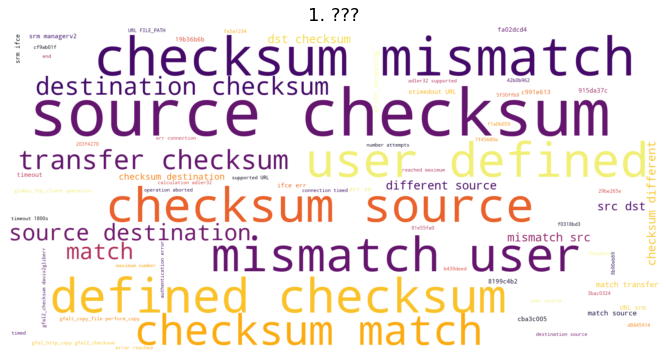

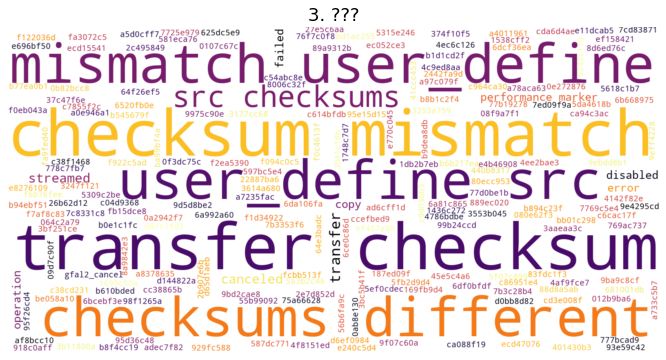

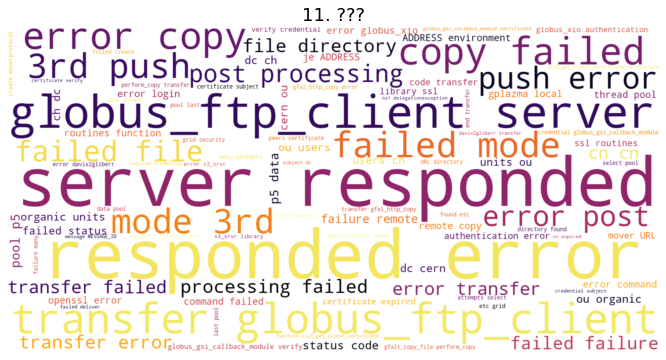

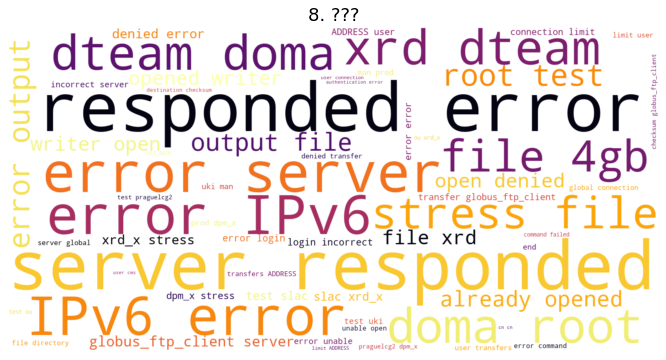

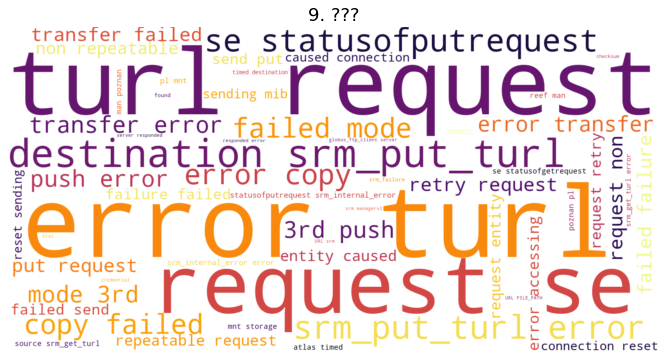

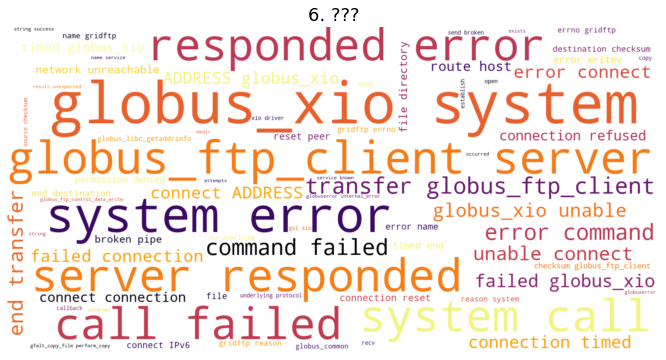

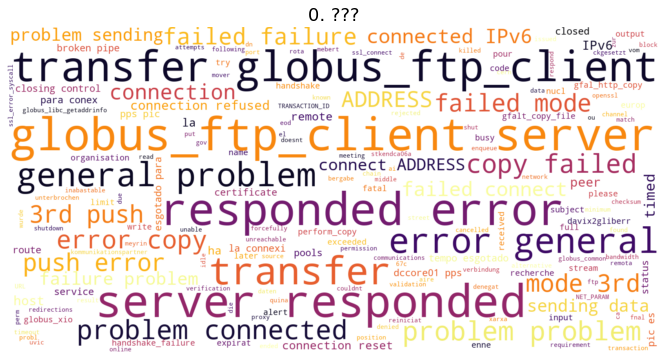

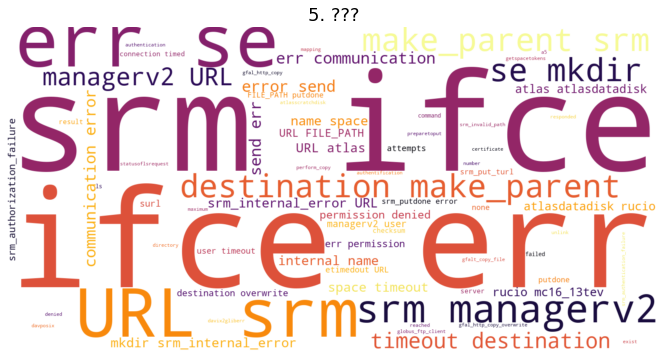

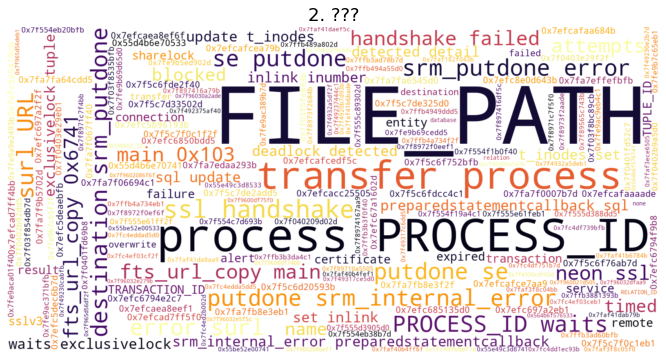

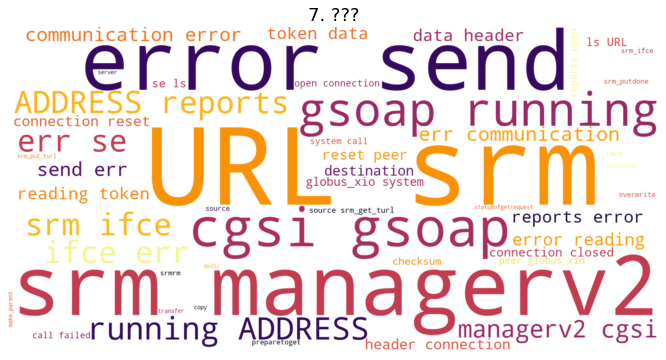

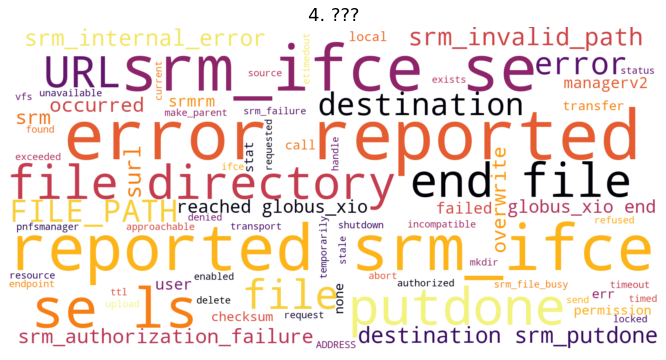

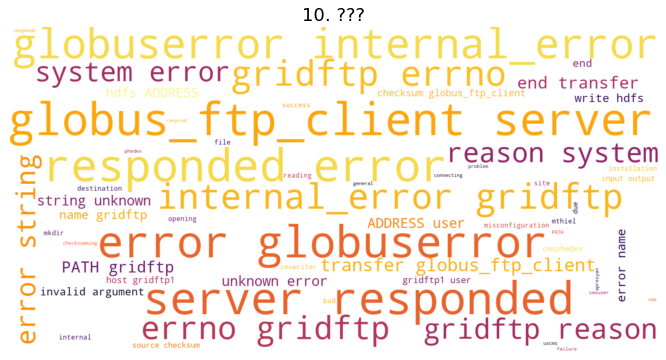

In [77]:
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt 
sns.set_context("paper", rc={"axes.titlesize":18,"axes.labelsize":22})

results_path = Path('''/eos/user/l/lclissa/SWAN_projects/rucio-log-clustering/
                        notebooks/results/{}/tokenclouds'''.format(results_folder))
results_path.mkdir(parents=True, exist_ok=True)

for label, tokens in zip(pd_cluster_tokens.prediction, pd_cluster_tokens.cluster_tokens):
    # Create and generate a word cloud image:
    wordcloud = wdcld.WordCloud(width=1600, height=800, background_color="white", min_font_size=11, colormap=matplotlib.cm.inferno).generate(' '.join(tokens))

    # Display the generated image:
    fig = plt.figure(figsize=(12,6))
    plt.title("{}. {}".format(label, descriptions[label].upper()))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    output_path = results_path / "Cluster_n{}_with_description.png".format(label)
    fig.savefig(output_path, format=str(output_path).split(".")[-1], bbox_inches='tight')

### Barplot 

Second alternative is a barplot in which tokens are ranked based on tf-idf measure in the cluster.

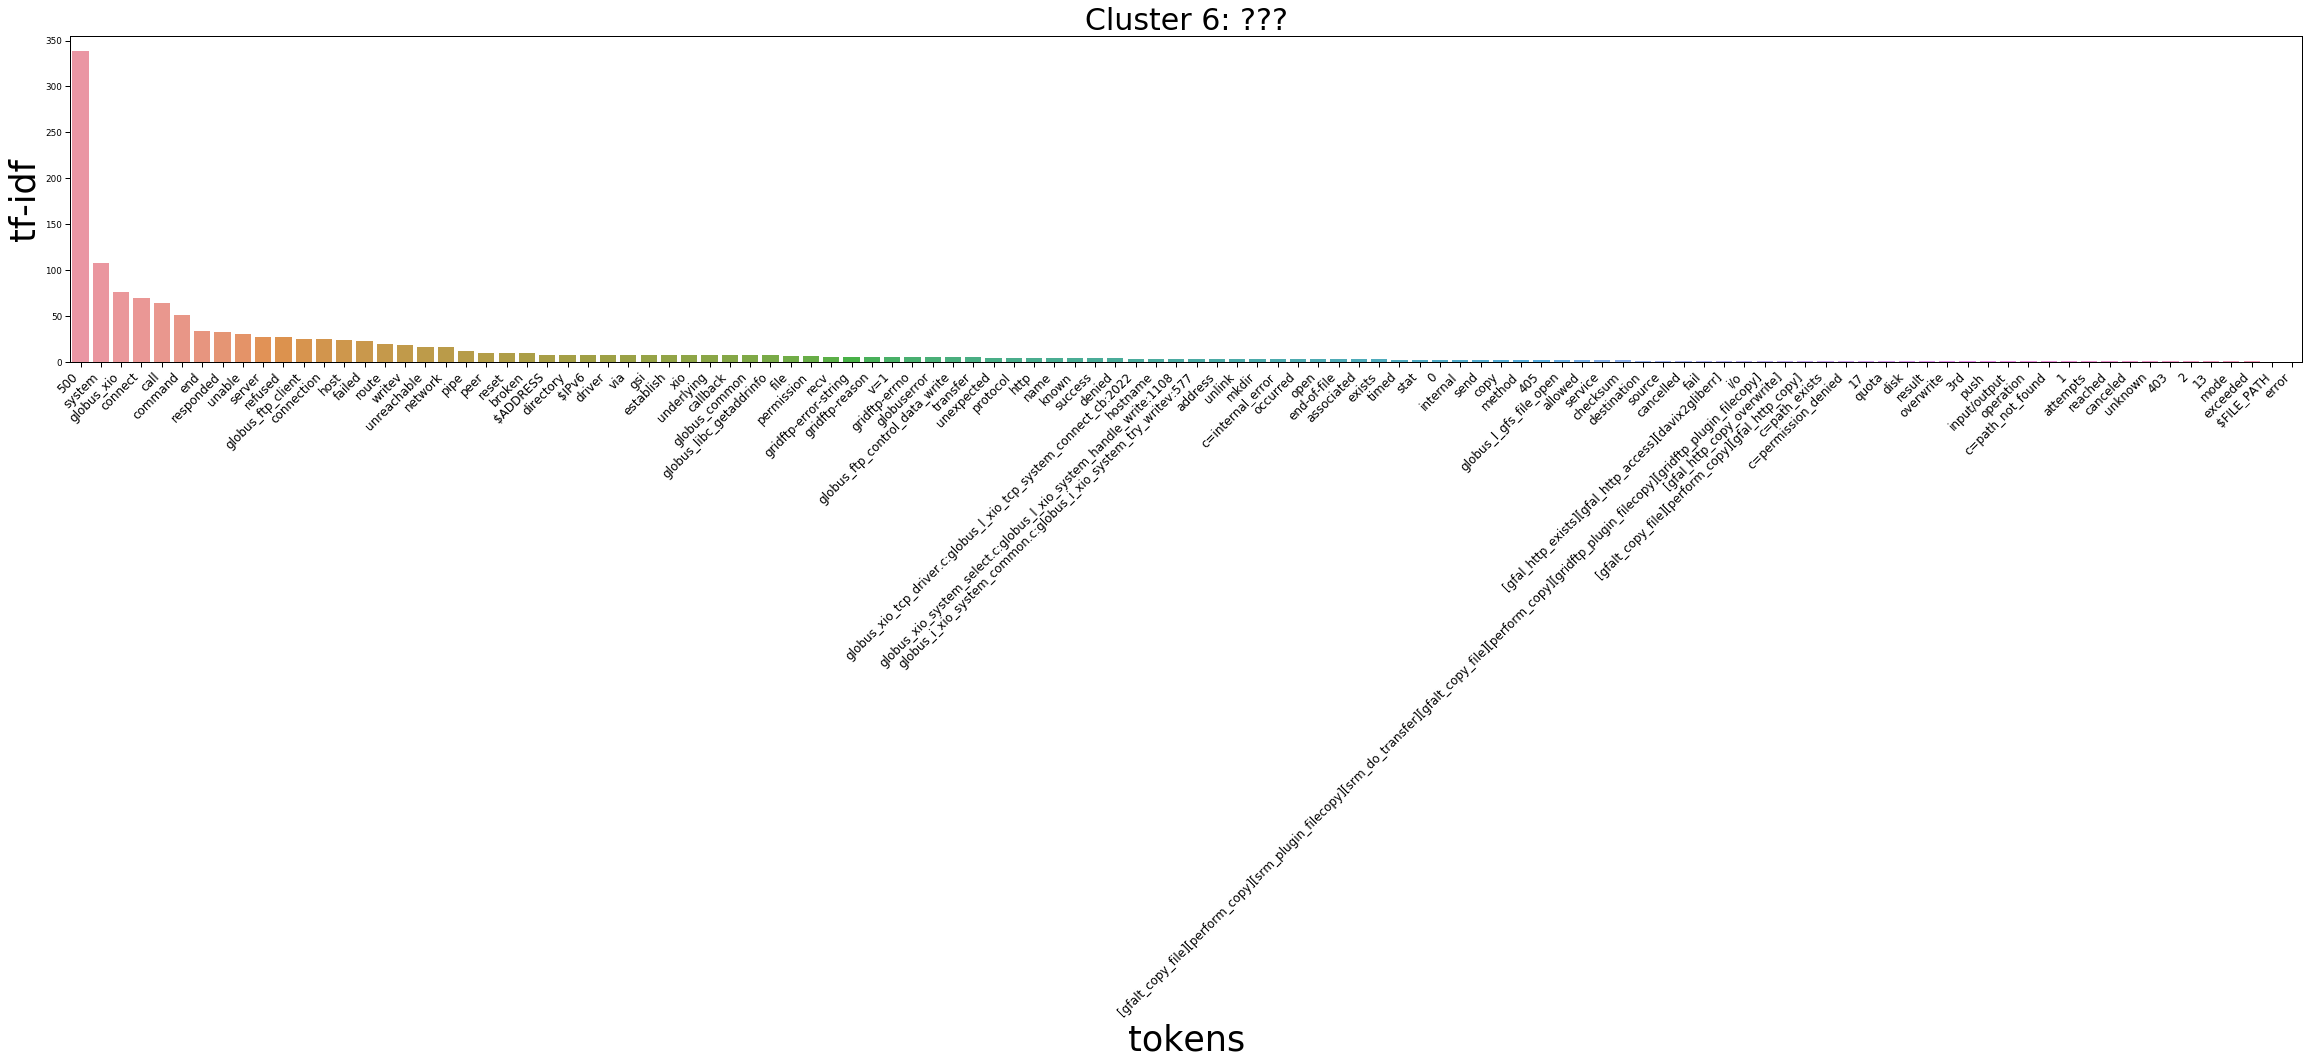

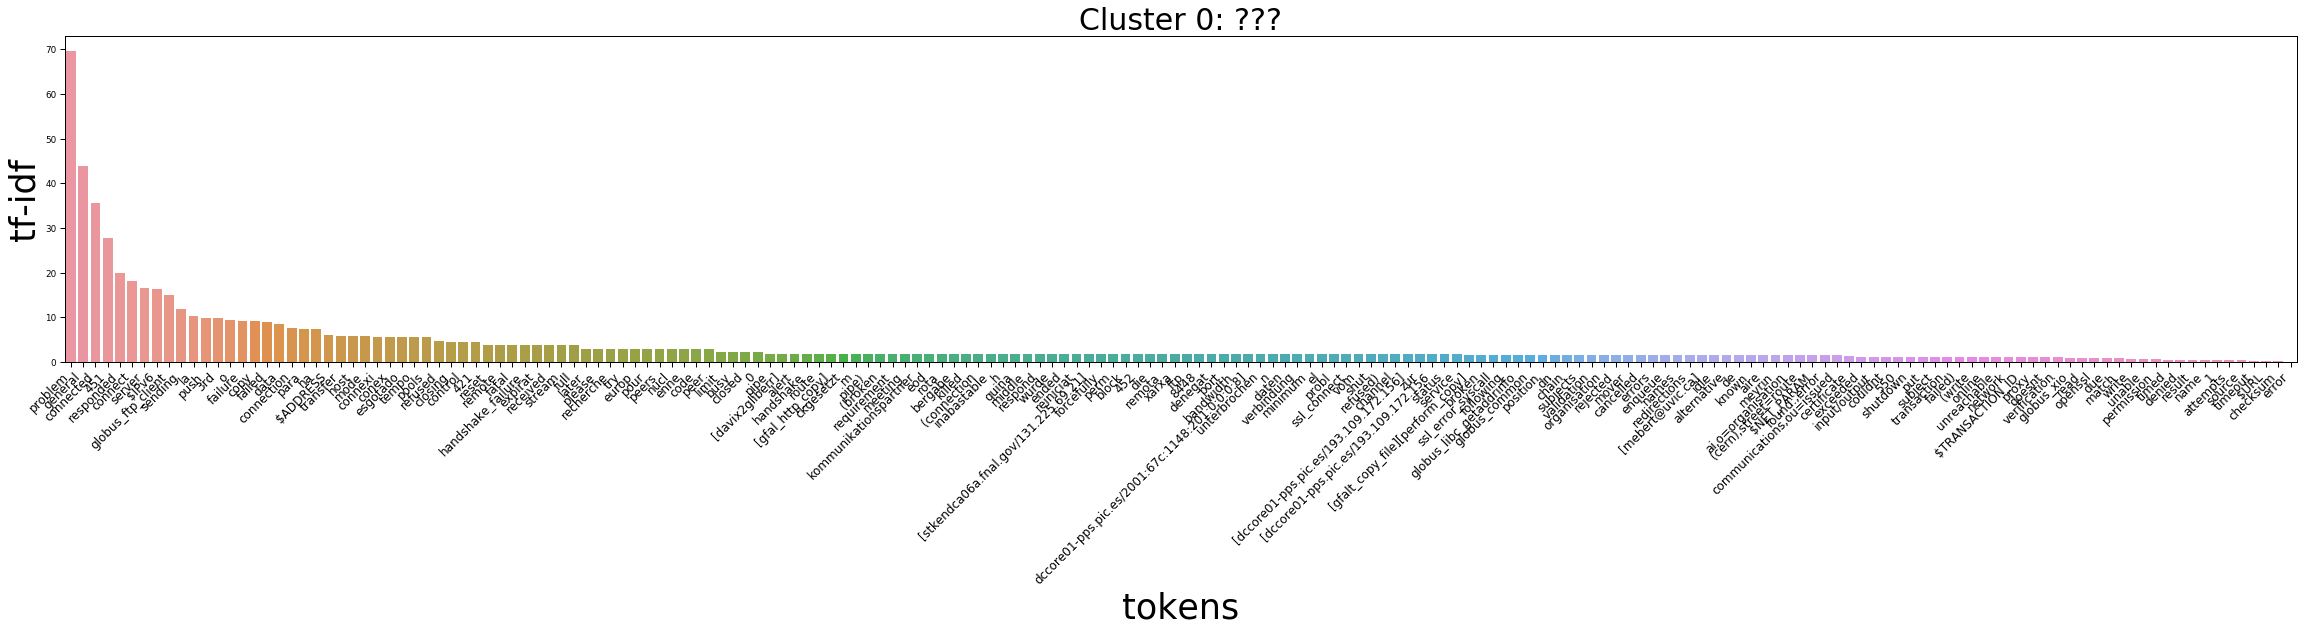

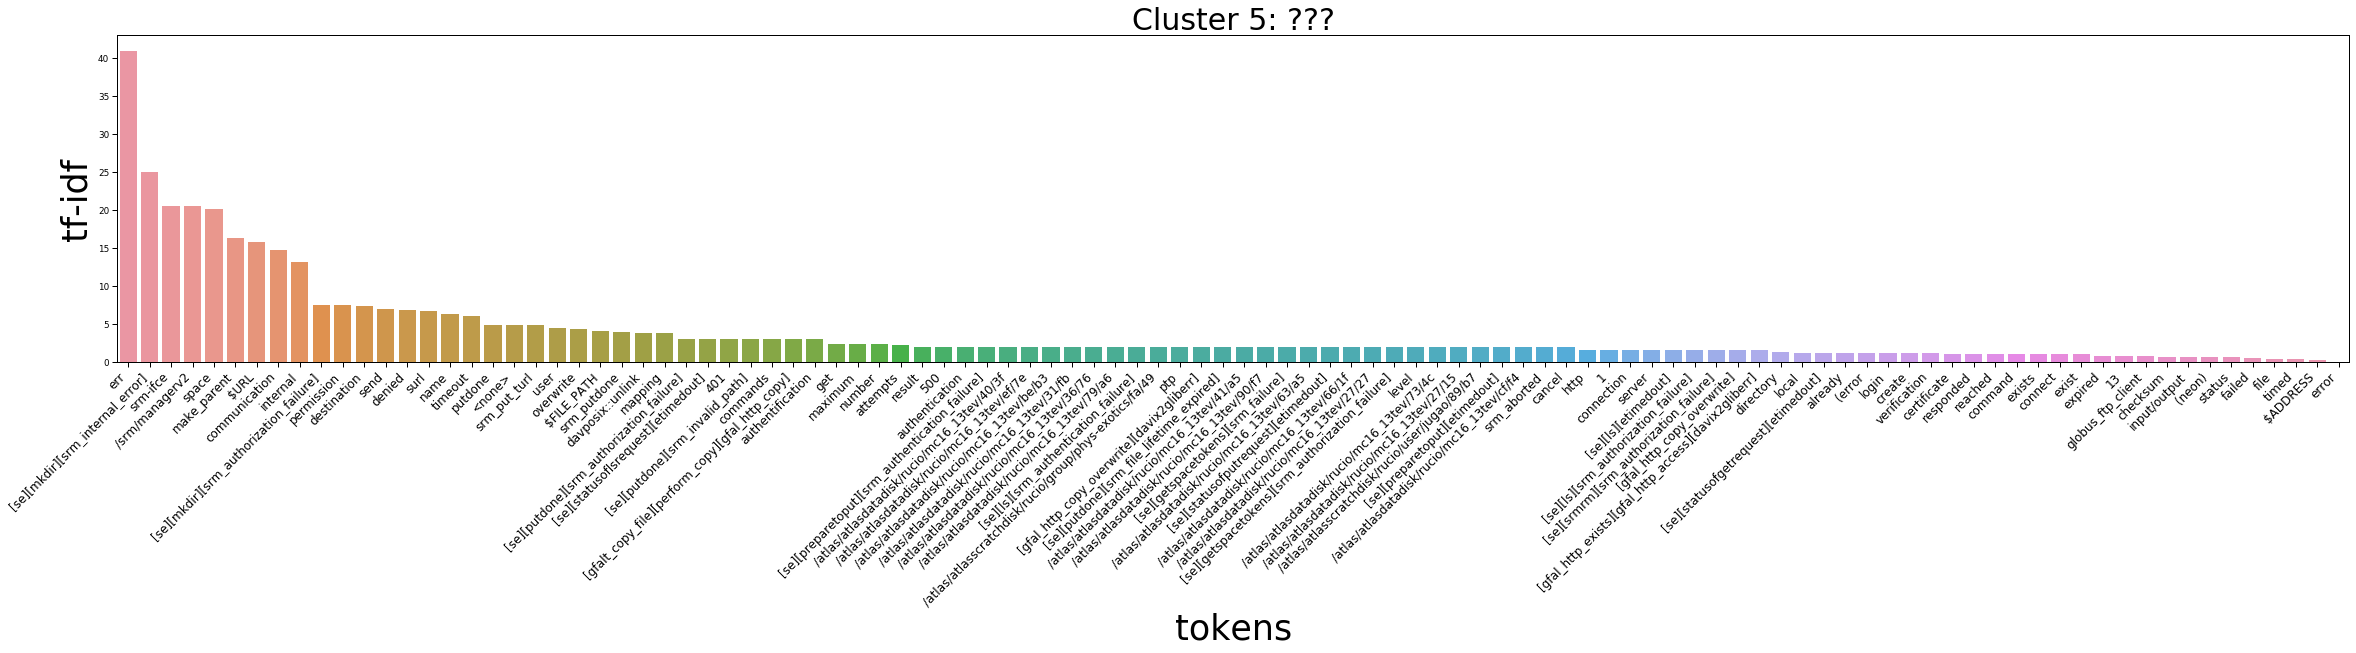

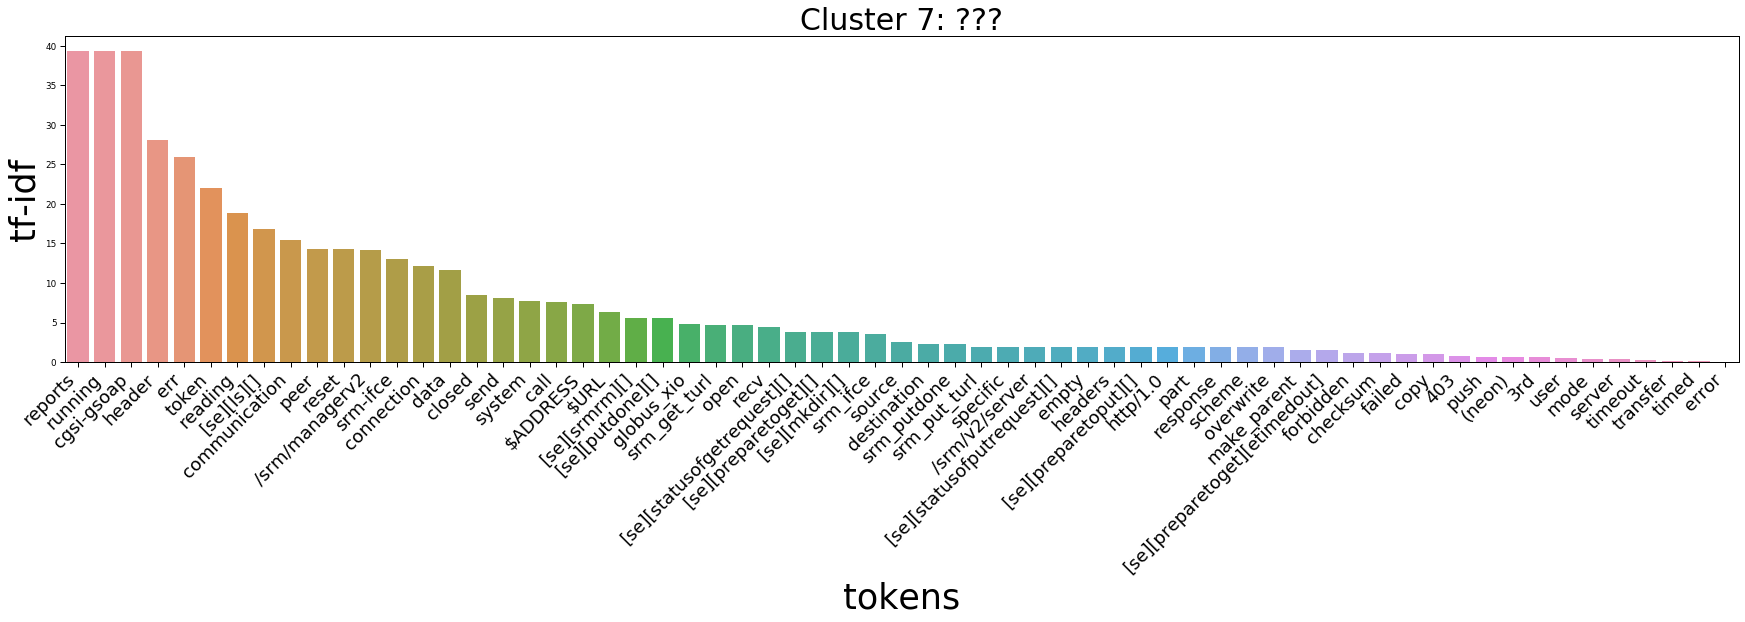

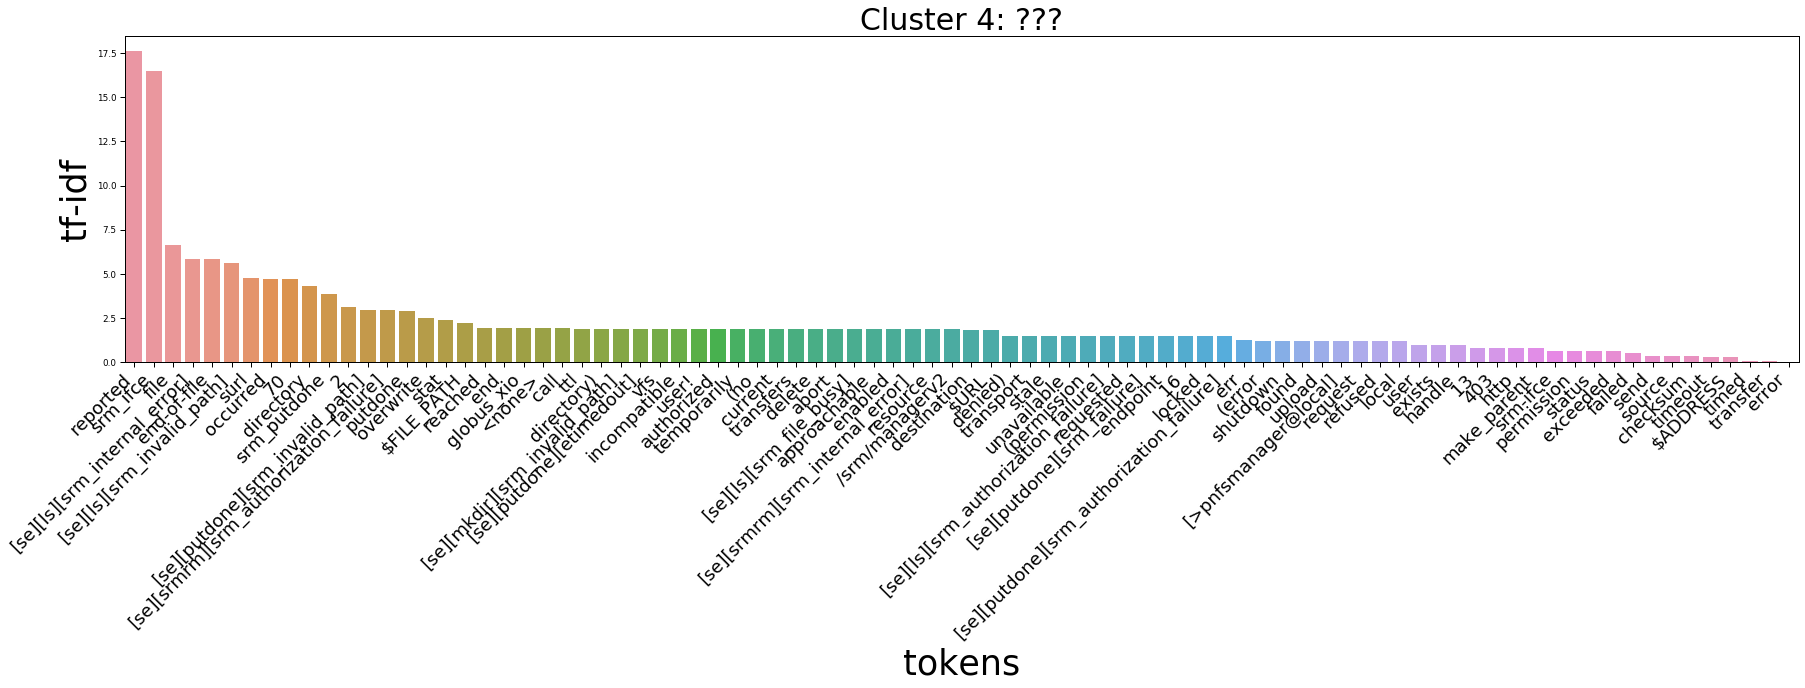

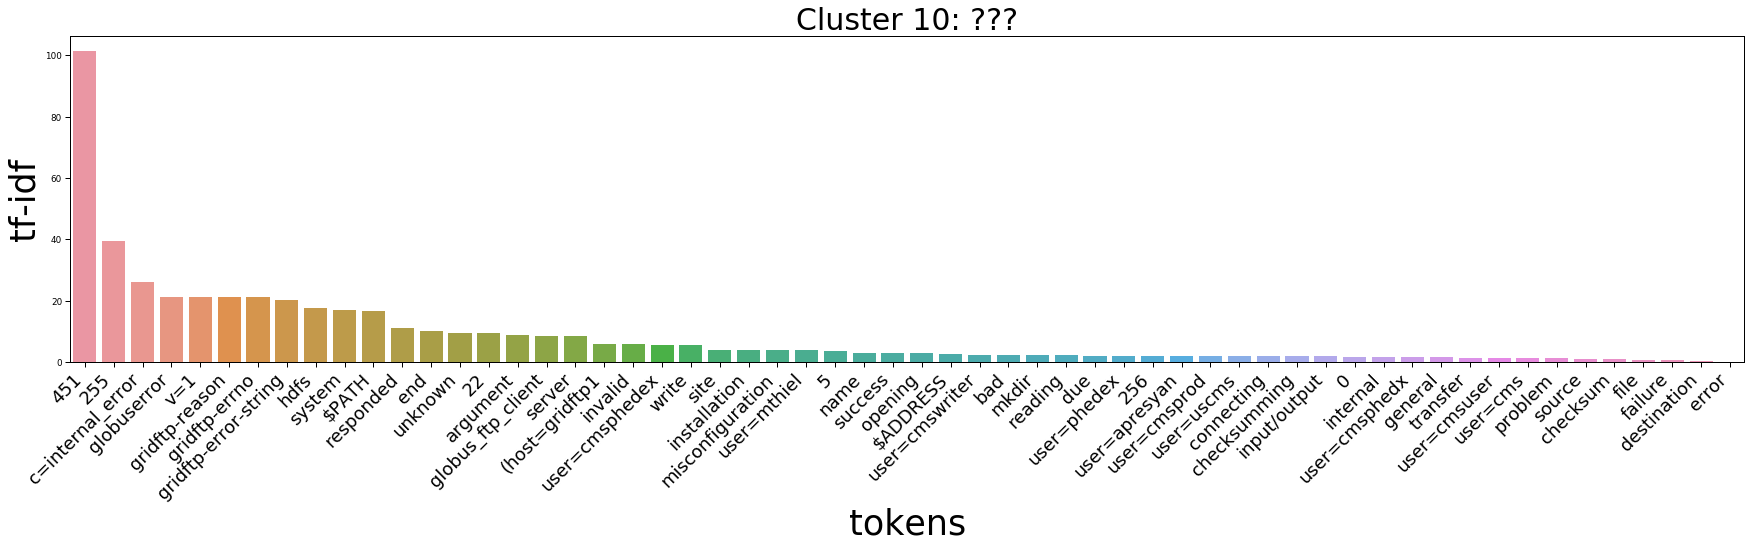

In [79]:
sns.set_context("paper", rc={"axes.titlesize":30,"axes.labelsize":35})

results_path = Path('''/eos/user/l/lclissa/SWAN_projects/
                    rucio-log-clustering/notebooks/results/{}/barplots'''.format(results_folder))
results_path.mkdir(parents=True, exist_ok=True)

for idx, row in enumerate(tks_freq.select("cluster_tokens","tf_idf", "prediction").collect()):
    
    # extract data
    y = row[1]
    x = [count_vec_model.vocabulary[x] for x in y.indices]#row[0]#.split()
    data = pd.DataFrame({"tokens": x,"tf-idf": y.values}).sort_values(by=['tf-idf'], ascending=False)
    
    if len(x) > 200:
        continue
    elif len(x)>100:
        font_size=12
        fig_size=(40,6)
    elif len(x)>50:
        font_size=18
        fig_size=(30,6)
    else:
        font_size=22
        fig_size=(30,6)

    fig, ax = plt.subplots(figsize=fig_size)
    _ = plt.title("Cluster {}: {}".format(row[2], descriptions[row[2]]))
    g = sns.barplot(ax=ax, x="tokens", y="tf-idf", data=data, )


    _ = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=font_size)
    _ = plt.show()
    output_path = results_path / "Cluster_n{}_with_description.png".format(row[2])
    fig.savefig(output_path, format=str(output_path).split(".")[-1], bbox_inches='tight')